# Modelo 3 - Red Neuronal

En este tercer modelo se utilizó una red neuronal para la predicción de los diferentes tipos de ataque. En este caso, se empleó la librería de [Keras](https://keras.io/) para la creción de la red neuronal secuencial. Además, se realizó un tratamiento adicional de la información para mejorar el desempeño.

A partir de las principales métricas de medición de desempeño de modelos, se comparó con los dos anteriores modelos (XGBoost y Voting Classifier) para identificar el más idoneo para la implementación de la solución de Machine Learning. Este análisis se dividió en los siguientes puntos:

* **Cargado de la base de información**: Lectura del archivo parquet donde se tiene almacenado el dataset.

* **Tratamiento de información**: Proceso de transformación de la información utilizando `StandardScaler` de sklearn con el objetivo de mejorar el desempeño de la red neuronal.

* **Definición y entrenamiento de Red Neuronal**: Creación de la topología de la red y de ajustes necesarios para adecuarla al formato de los datos de entrada y predicción.

* **Comentarios Finales:** Revisión de resultados de red neuronal y desempeño con respecto a los demás modelos analizados.

# 1. Cargado de Base

Para este ejercicio se utilizó la base de **CIC-DDoS2019**, que se carga a continuación junto con las demas librerías que se utilizaron en el ejercicio:

In [ ]:
# Montado de drive para realizar el análisis
from google.colab import drive
drive.mount('/content/drive')
#Librerías Utilizadas
import pandas as pd # Manipulación de datos
pd.options.display.float_format = '{:.1f}'.format # Adecuar formato de salidas de tablas a 1 posición decimal
import seaborn as sns # Creación de gráficas
import matplotlib.pyplot as plt # Formato de gráficas
import numpy as np
# Herramientas de análisis de modelos
from sklearn.model_selection import train_test_split, GridSearchCV # Creación set entrenamiento - validación
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score # Medición de precisión
from sklearn.preprocessing import LabelEncoder
# Librerías modelo Red Neuronal
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils import plot_model
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping

Mounted at /content/drive


Con estas librerías se realizó el cargue de la información, que corresponde a 431371 filas y 39 columnas y donde no hay valores nulos:

In [ ]:
df_CIC2019_corr = pd.read_parquet("/content/drive/MyDrive/Tesis - Machine Learning/Tesis - Machine Learning/E - Modelo predicción/Base/CICIDS2019_2.parquet")

In [ ]:
df_CIC2019_corr.head(5)

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Flow Bytes/s,Flow Packets/s,Fwd PSH Flags,Fwd Header Length,...,Fwd Seg Size Min,Label,Packet Length Mean,Fwd Packet Length Mean,Active Mean,Fwd IAT Mean,Idle Mean,Bwd IAT Mean,Bwd Packet Length Mean,Flow IAT Mean
0,17,48,4,0,1616.0,0.0,33666666.7,83333.3,0,80,...,20,DrDoS_NTP,411.2,404.0,0.0,16.0,0.0,0.0,0.0,16.0
1,17,557,112,0,49280.0,0.0,88473967.7,201077.2,0,0,...,0,DrDoS_NTP,440.0,440.0,0.0,5.0,0.0,0.0,0.0,5.0
2,6,323228,14,12,1736.0,526.0,6998.2,80.4,0,304,...,20,Benign,83.8,124.0,0.0,24863.7,0.0,15038.7,43.8,12929.1
3,17,46917,2,2,86.0,118.0,4348.1,85.3,0,40,...,20,Benign,49.4,43.0,0.0,3.0,0.0,2.0,59.0,15639.0
4,17,254,58,0,25520.0,0.0,100472440.9,228346.5,0,-58,...,-1,DrDoS_NTP,440.0,440.0,0.0,4.5,0.0,0.0,0.0,4.5


# 2. Tratamiento de información:

Como punto de referencia, se crearon los dataset de entrenamiento y validación para esta base, con una proporción de 80-20. A su vez, se creó un normalizador (Standard Scaler) que permite transformar las columnas mediante la remoción de la media y el escalado a la varianza unitaria, resumido por la siguiente transformación:

$$z=(x-u)/s$$

Donde $u$ es la media y $s$ la desviación estándar.


In [ ]:
# Variables a entrenar
X1 = df_CIC2019_corr.drop(columns="Label")
# Variable objetivo - sospechosos
le = LabelEncoder()
#Conversión de texto a numero
encoded = le.fit_transform(df_CIC2019_corr["Label"])
y = encoded
# División entrenamiento - rest con ratio de 80% - 20%
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)
# Normalizar inputs
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Posteriormente, para poder entenar a la red neuronal se utiliza one-hot encoding que realiza la siguiente transformación a los tipos de ataques (Variable Y):

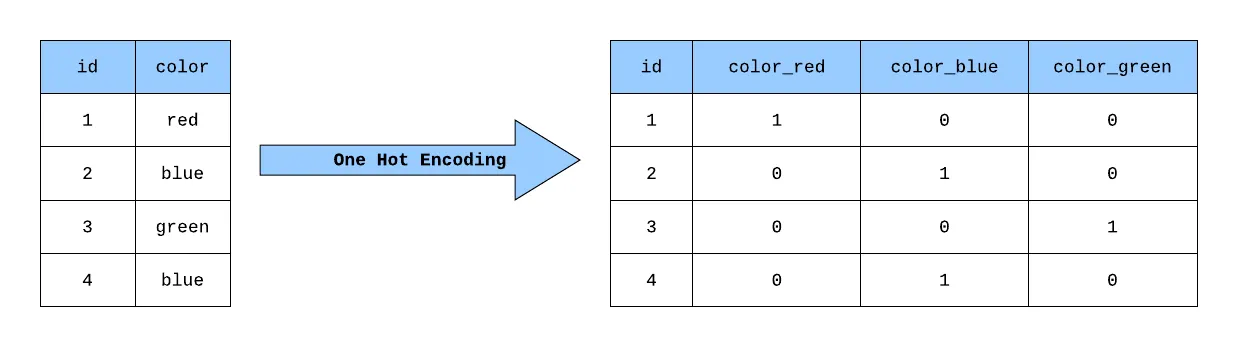

Esta transformación convierte las clases categóricas en vectores binarios, lo que facilita el entrenamiento del modelo de red neuronal para problemas de clasificación multicategoría.

Fuente: https://towardsdatascience.com/building-a-one-hot-encoding-layer-with-tensorflow-f907d686bf39

In [ ]:
# Convertir y_train e y_test a formato one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=12)
y_test_one_hot = to_categorical(y_test, num_classes=12)

# 3. Definición y entrenamiento de red neuronal

Posteriormente, se creó una [Red Neuronal Secuencial](https://keras.io/guides/sequential_model/) multicapa, iniciando con una capa de entrada con 64 neuronas, conectada con otra capa oculta de 64 neuronas, y finalizando una capa de salida de 12 neuronas, correspondientes a los 12 tipos de ataque.

Se utilizó el [optimizador Adam](https://www.geeksforgeeks.org/adam-optimizer/), que es un tipo de descenso de gradiente estocástico, en conjunto con la pérdida de [categorical crossentropy](https://medium.com/@francescofranco_39234/categorical-crossentropy-with-keras-2ac52d5351b0), adecuada para los problemas de clasificación con más de dos categorías. La métrica a monitorear es la precisión.

Finalmente, se añadió la opción de [Early Stopping](https://keras.io/api/callbacks/early_stopping/), que detiene el entrenamiento si la métrica de pérdida no mejora después de 10 iteraciones, con el objetivo de evitar el [overfitting](https://www.aprendemachinelearning.com/que-es-overfitting-y-underfitting-y-como-solucionarlo/) con los datos de entrenamiento.

In [ ]:
# Creación de red
model = Sequential()
# Capa de entrada
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu', name="Entrada"))
# Capa Dropout para evitar overfitting
model.add(Dropout(0.5,name="Dropout_1"))
# Capa intermedia
model.add(Dense(64, activation='relu', name="Intermedia"))
# Capa Dropout para evitar overfitting)
model.add(Dropout(0.5, name="Dropout_2"))
# Capa de salida
model.add(Dense(12, activation='softmax', name="Salida"))
# Compilación del modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Utilizar early stopping para prevenir sobreajuste
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

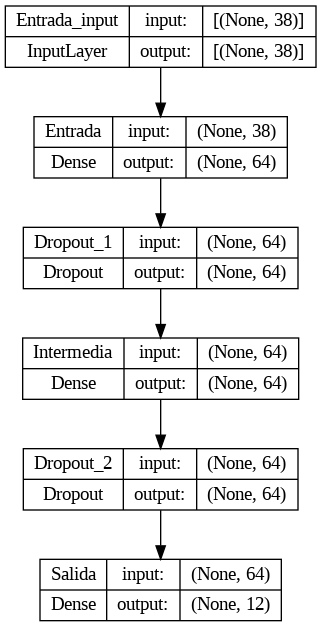

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

Con esta configuración se entrena el modelo con 20 épocas (epochs) utilizando un muestreo de validación en el conjunto de entrenamiento para evitar el overfitting.

In [ ]:
%%time
model_obj=model.fit(X_train, y_train_one_hot, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping]) # epochs=20

Epoch 1/20
8628/8628 [==============================] - 15s 2ms/step - loss: 0.3212 - accuracy: 0.9104 - val_loss: 0.1685 - val_accuracy: 0.9471
Epoch 2/20
8628/8628 [==============================] - 13s 1ms/step - loss: 0.1965 - accuracy: 0.9394 - val_loss: 0.1473 - val_accuracy: 0.9539
Epoch 3/20
8628/8628 [==============================] - 13s 1ms/step - loss: 0.1779 - accuracy: 0.9447 - val_loss: 0.1331 - val_accuracy: 0.9551
Epoch 4/20
8628/8628 [==============================] - 13s 1ms/step - loss: 0.1710 - accuracy: 0.9466 - val_loss: 0.1283 - val_accuracy: 0.9564
Epoch 5/20
8628/8628 [==============================] - 12s 1ms/step - loss: 0.1635 - accuracy: 0.9484 - val_loss: 0.1268 - val_accuracy: 0.9566
Epoch 6/20
8628/8628 [==============================] - 13s 2ms/step - loss: 0.1601 - accuracy: 0.9510 - val_loss: 0.1175 - val_accuracy: 0.9627
Epoch 7/20
8628/8628 [==============================] - 13s 1ms/step - loss: 0.1565 - accuracy: 0.9532 - val_loss: 0.1098 - val_ac

Luego se calcularon las principales métricas de desempeño:

- Precisión
- Exactitud
- Exhaustividad (recall)


In [ ]:
y_model = model.predict(X_test)
y_model = np.argmax(y_model, axis=1)
#Precisión
acc = accuracy_score(y_test,y_model)
print(f"Precisión: {acc}")
#Recall
rec = recall_score(y_test,y_model, average= "weighted") # Parametro weighted para calcular de acuerdo con cantidad
print(f"Recall: {rec}")
# F1 - Score
f1 = f1_score(y_test,y_model, average= "weighted") # Parametro weighted para calcular de acuerdo con cantidad
print(f"F1 score: {f1}")

2697/2697 [==============================] - 3s 1ms/step
Precisión: 0.9681715444798609
Recall: 0.9681715444798609
F1 score: 0.9649060753864063


Se identifica que, la precisión del modelo es cercana a 97%, aproximadamente un 1% menor que el modelo de Voting y un 1.5% menor que el de XGBoost. Sin embargo, en estos tres modelos, los tipos de ataque con mayor número de registros tienen un porcentaje de precisión cercano al 100% mientras que en los demás se reduce considerablemente. Un caso particular es el de WebDDos donde no se predice correctamente ninguno de los ataques:

<Axes: >

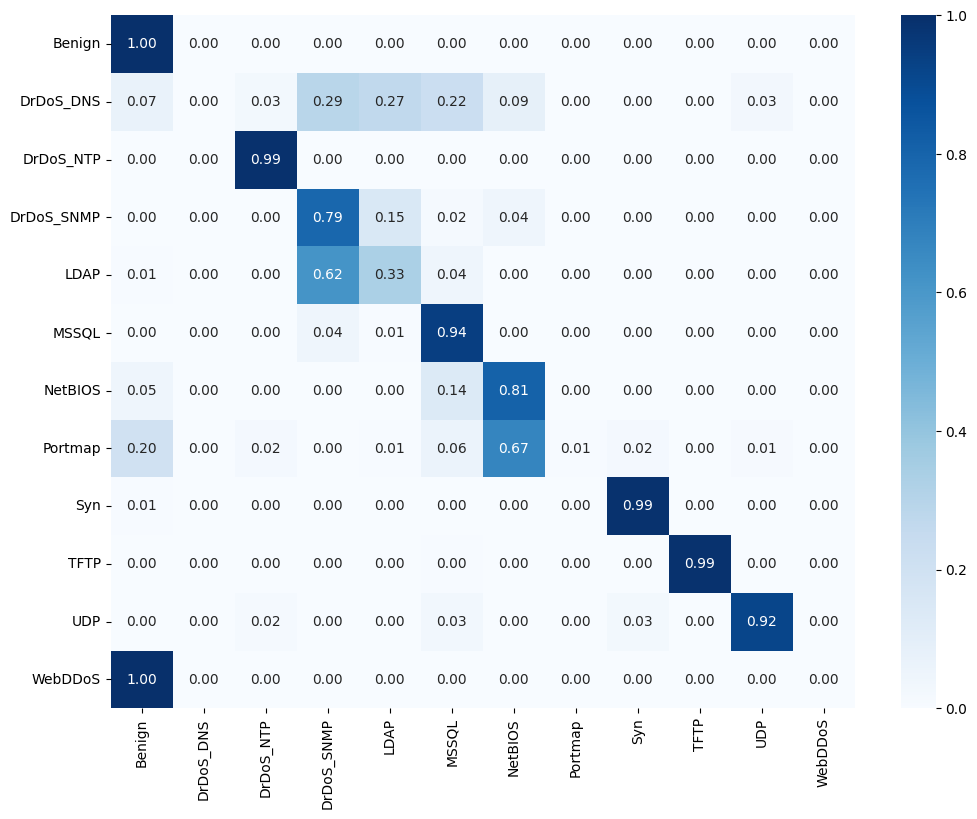

In [ ]:
# Matriz Normalizada
plt.figure(figsize=(12,9))
cm=confusion_matrix(y_test, y_model)
# Proceso de normalización
cm_normalized= cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized,annot=True, fmt=".2f", cmap="Blues", xticklabels=le.classes_,yticklabels=le.classes_)

Esto se encuentra respaldado por los resultados consolidados por modelo, en donde los ataques con mayor número de registros tienen un mejor desempeño:

In [ ]:
print(classification_report(y_test, y_model))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19542
           1       0.50      0.00      0.00       771
           2       0.99      0.99      0.99     24236
           3       0.34      0.79      0.48       526
           4       0.44      0.33      0.38       718
           5       0.81      0.94      0.87      2906
           6       0.49      0.81      0.61       257
           7       0.33      0.01      0.01       153
           8       0.98      0.99      0.98      9857
           9       1.00      0.99      1.00     19791
          10       0.99      0.92      0.95      7504
          11       0.00      0.00      0.00        14

    accuracy                           0.97     86275
   macro avg       0.65      0.65      0.61     86275
weighted avg       0.97      0.97      0.96     86275



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Comentarios Finales

* El modelo de red neuronal tuvo el peor desempeño en comparación con los otros 2 modelos, ya que en las 3 métricas de referencia se obtuvieron resultados menores.

* Para identificar el efecto de cada una de las variables en la predicción final, se requieren métodos como SHAP, ya que el funcionamiento interno de las redes neuronales es equivalente a un modelo de caja negra. Además, al ser un problema con más de dos categorías a predecir, la explicabilidad es más complicada a comparación de los modelos binarios

* La matriz de confusión muestra las mismas incidencias de predicción para los tipos de ataque con un número menor de registros.

* Se identifica como una opción adicional dividir la predicción en dos modelos, diviendo las etiquetas de acuerdo con el total de registros disponibles.